In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/breast-cancer-wisconsin-diagnostic/__results__.html
/kaggle/input/breast-cancer-wisconsin-diagnostic/__resultx__.html
/kaggle/input/breast-cancer-wisconsin-diagnostic/__notebook__.ipynb
/kaggle/input/breast-cancer-wisconsin-diagnostic/__output__.json
/kaggle/input/breast-cancer-wisconsin-diagnostic/custom.css
/kaggle/input/breast-cancer-wisconsin-diagnostic/__results___files/__results___20_1.png
/kaggle/input/breast-cancer-wisconsin-diagnostic/__results___files/__results___31_3.png
/kaggle/input/breast-cancer-wisconsin-diagnostic/__results___files/__results___29_3.png
/kaggle/input/breast-cancer-wisconsin-diagnostic/__results___files/__results___40_0.png
/kaggle/input/breast-cancer-wisconsin-diagnostic/__results___files/__results___31_1.png
/kaggle/input/breast-cancer-wisconsin-diagnostic/__results___files/__results___37_1.png
/kaggle/input/breast-cancer-wisconsin-diagnostic/__results___files/__results___33_1.png
/kaggle/input/breast-cancer-wisconsin-diagnostic/__results_

# EDA

## Load Libraries

In [2]:
# pip install imblearn

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.neighbors import LocalOutlierFactor


from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import shap
import joblib

import missingno as msno
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings("ignore")


## Load Dataset

In [4]:
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target
df['diagnosis'] = df['target'].map({0: 'malignant', 1: 'benign'})


In [5]:
df.head(10)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0,malignant
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0,malignant
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0,malignant
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0,malignant
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0,malignant
5,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,0.2087,0.07613,...,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440,0,malignant
6,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,0.1794,0.05742,...,153.20,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368,0,malignant
7,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,0.2196,0.07451,...,110.60,897.0,0.1654,0.3682,0.2678,0.1556,0.3196,0.11510,0,malignant
8,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,0.2350,0.07389,...,106.20,739.3,0.1703,0.5401,0.5390,0.2060,0.4378,0.10720,0,malignant
9,12.46,24.04,83.97,475.9,0.11860,0.23960,0.22730,0.08543,0.2030,0.08243,...,97.65,711.4,0.1853,1.0580,1.1050,0.2210,0.4366,0.20750,0,malignant


## Initial Inspection

In [6]:
print("Shape: ", df.shape)
print("\n","*****"*15, "\n")

print("Information: \n",df.info())
print("\n","*****"*15, "\n")

print("Stats: \n",df.describe().T)
print("\n","*****"*15, "\n")

print("Uniqueness: \n", df.nunique())
print("\n","*****"*15, "\n")

print("Is Null ? \n", df.isnull().sum())
print("\n","*****"*15, "\n")


Shape:  (569, 32)

 *************************************************************************** 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-nul

## Missing Value Visualization

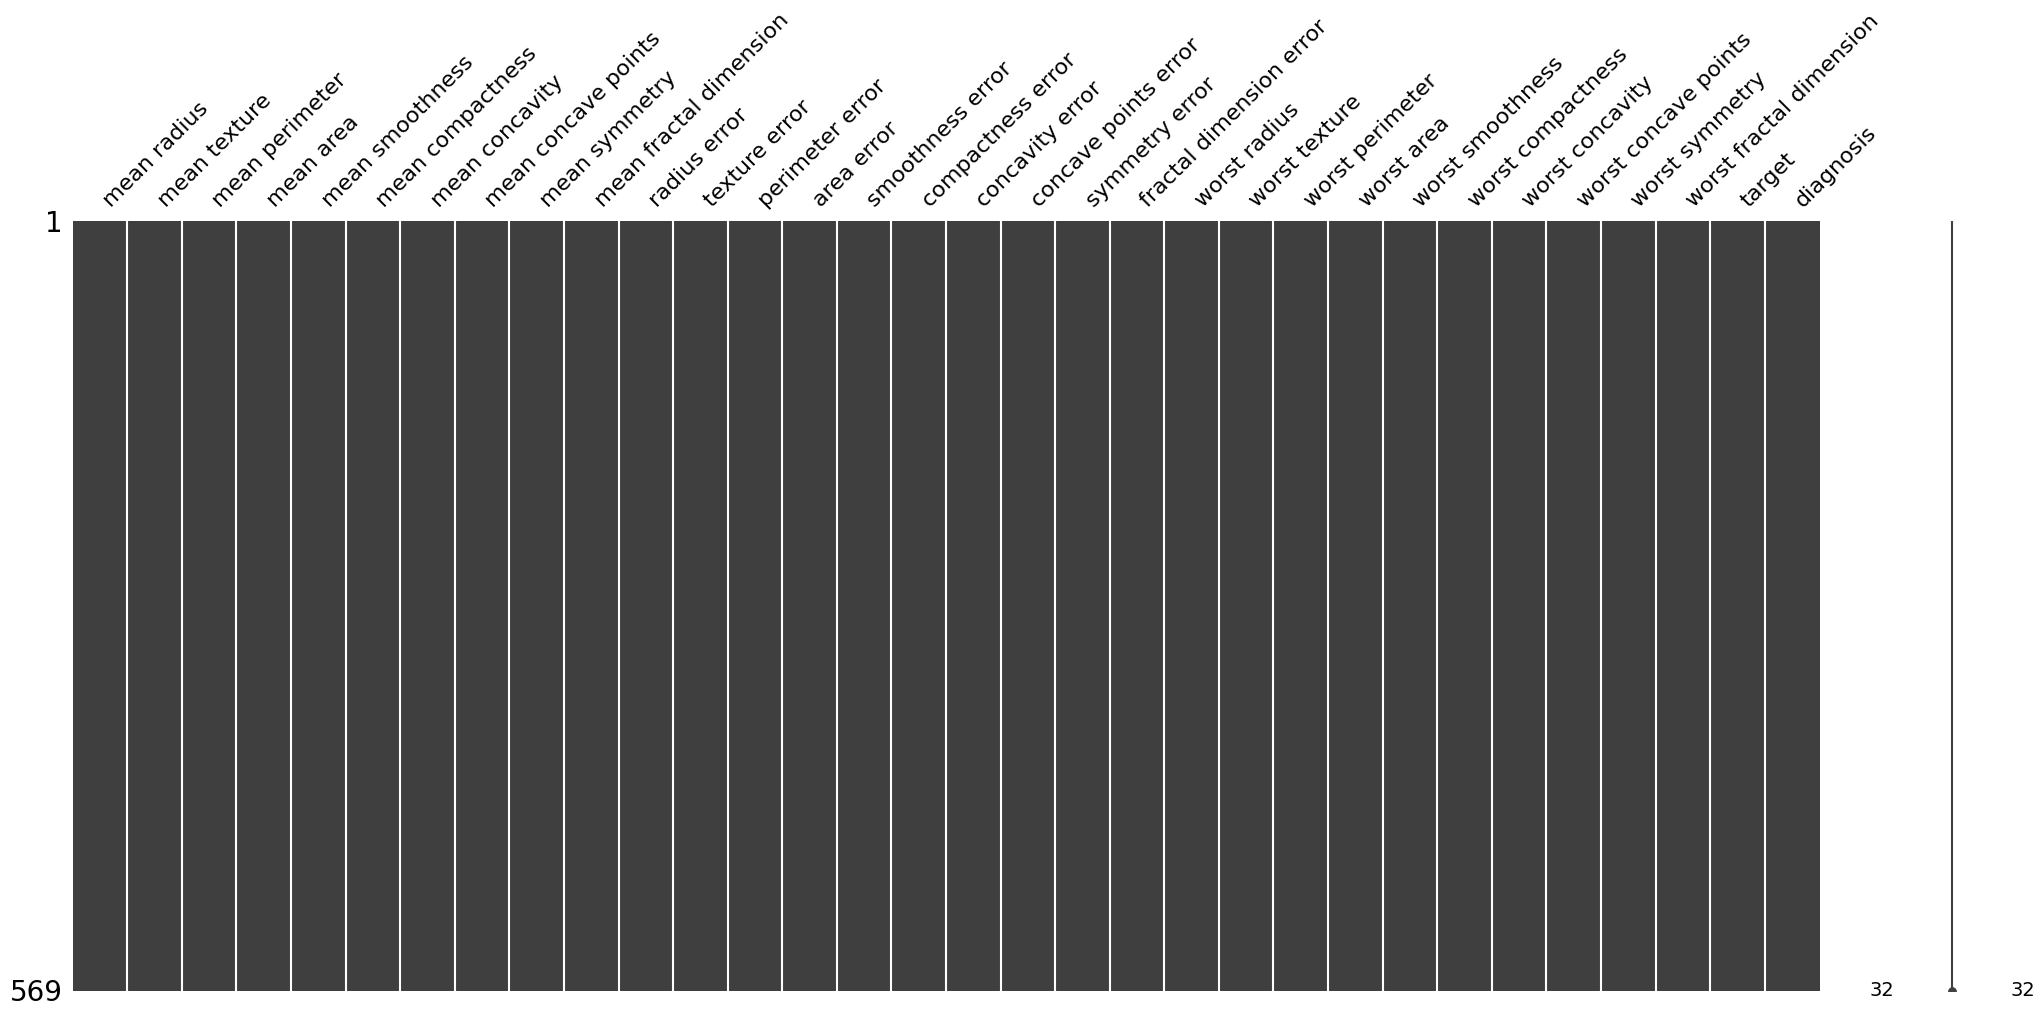

In [7]:
msno.matrix(df)
plt.show()

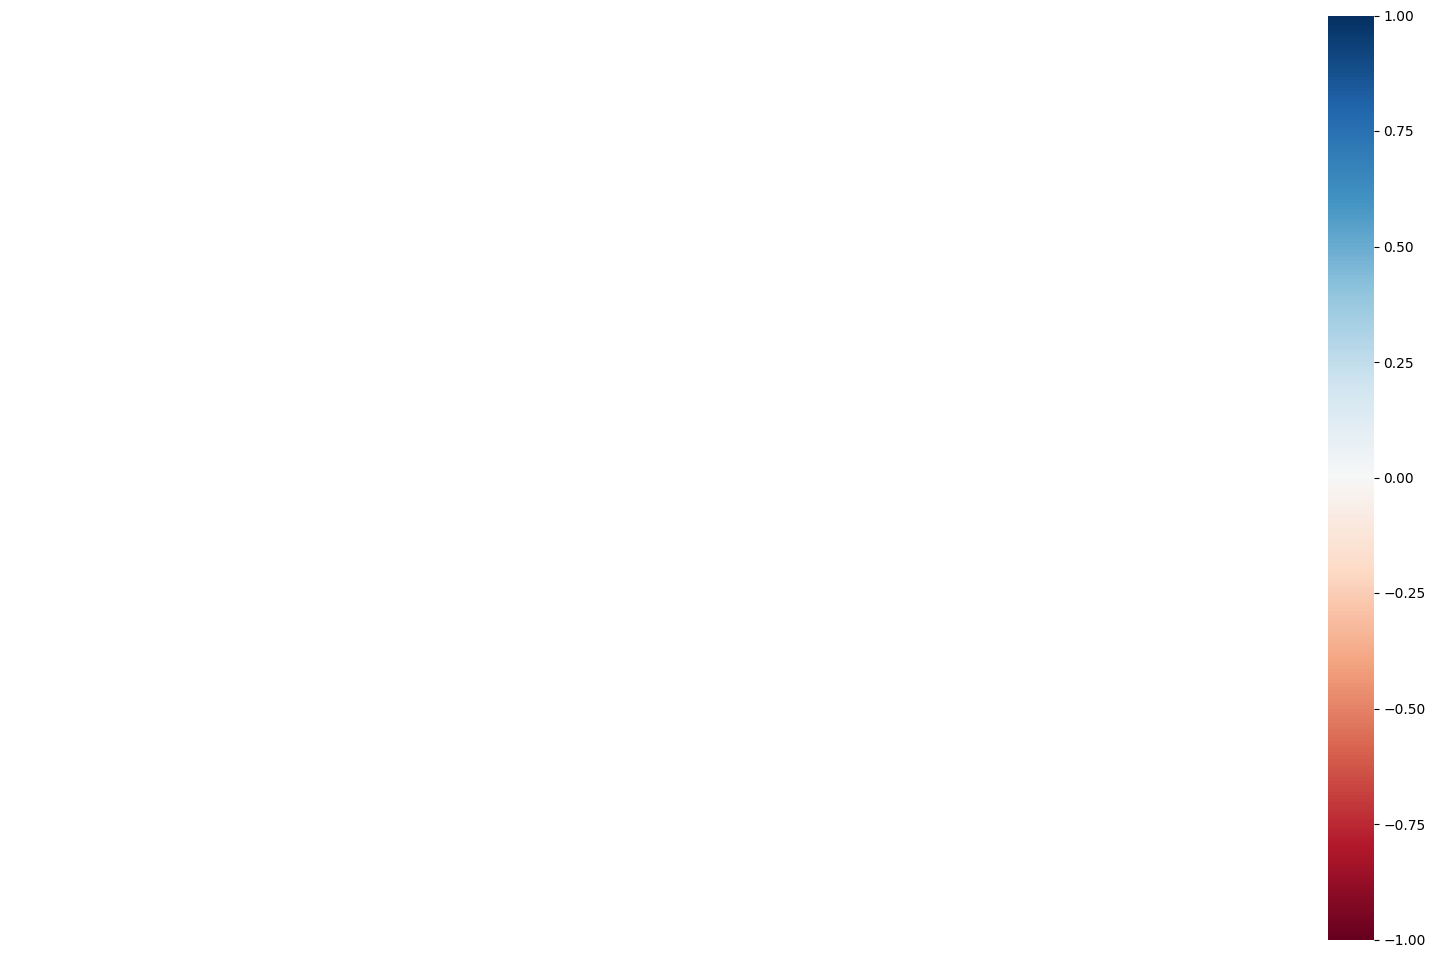

In [8]:
msno.heatmap(df)
plt.show()


## Target Distribution

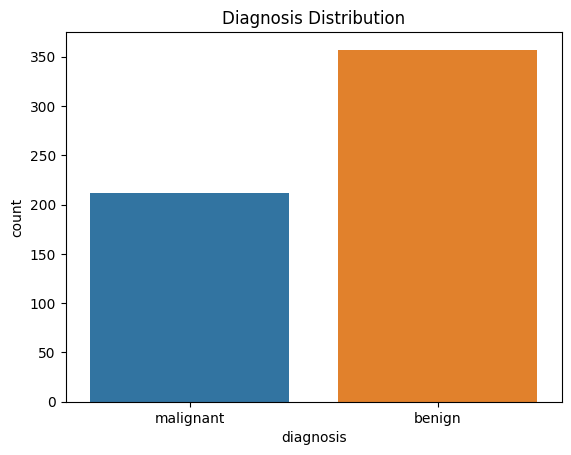

In [9]:
sns.countplot(x='diagnosis', data=df)
plt.title("Diagnosis Distribution")
plt.show()

## Numerical Distribution and Outliers

Skewness of  0.9423795716730993


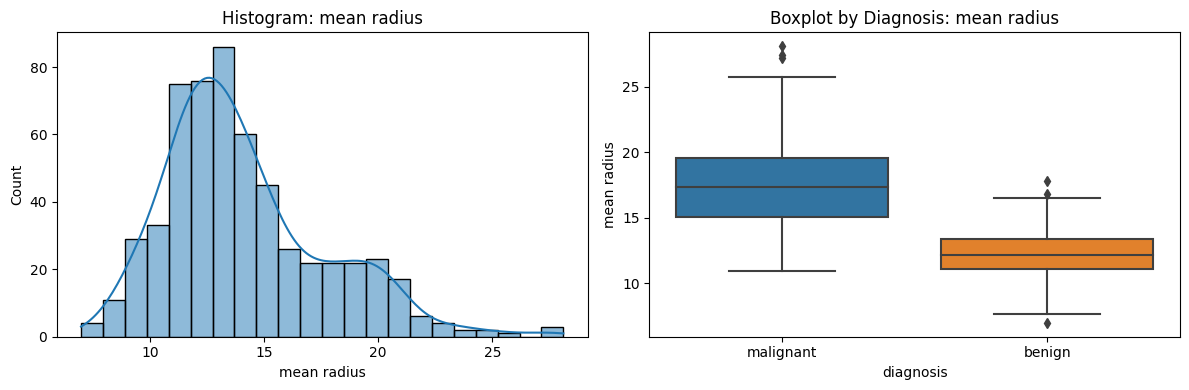

Skewness of  0.6504495420828159


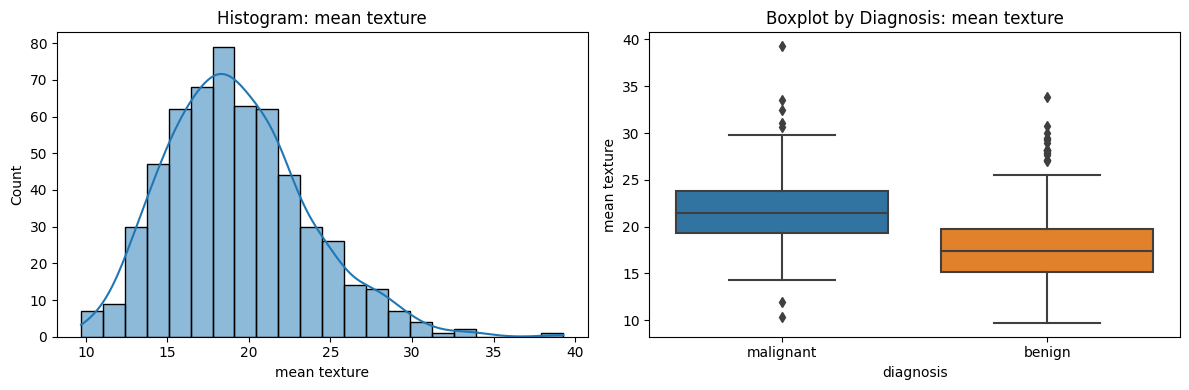

Skewness of  0.99065042539301


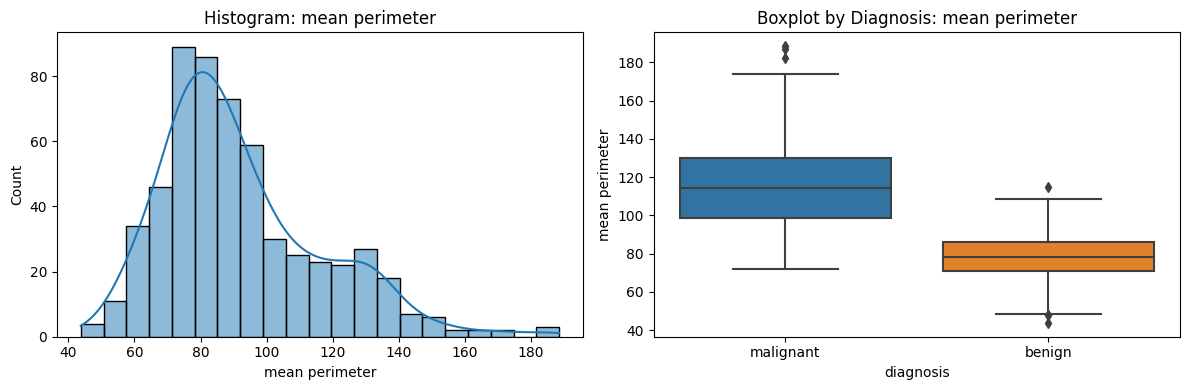

Skewness of  1.645732175624042


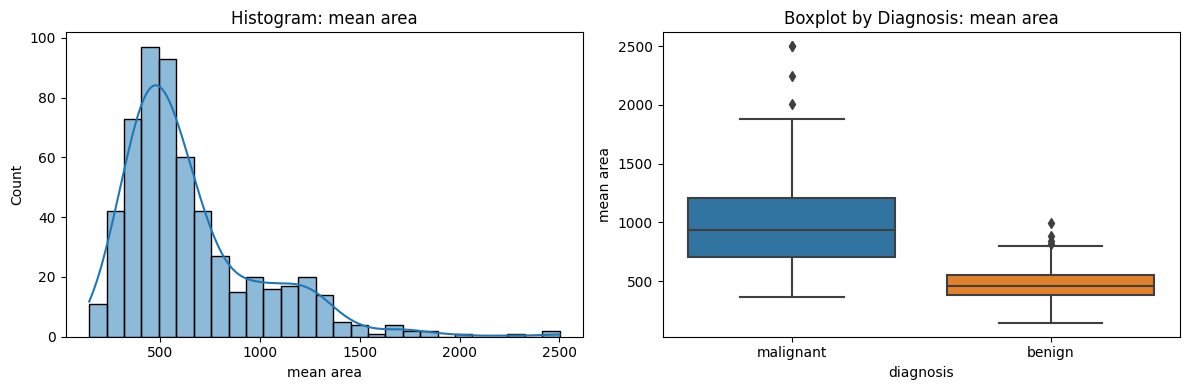

Skewness of  0.4563237648195646


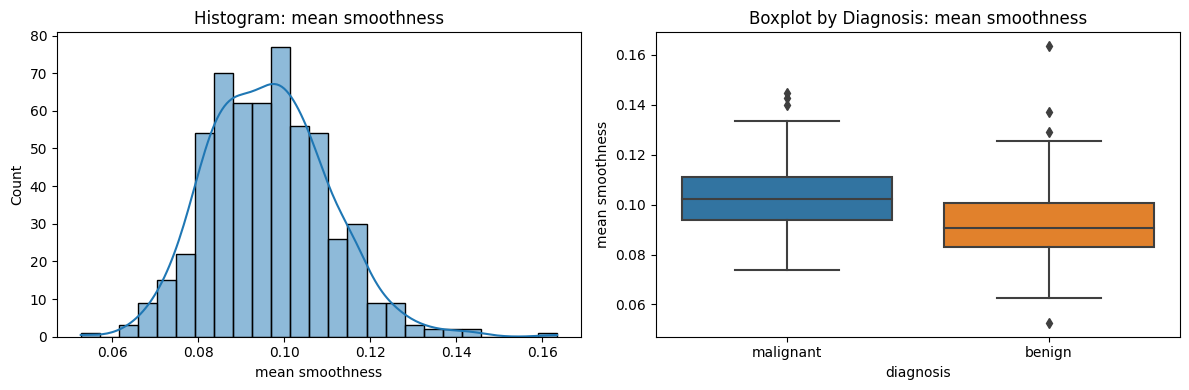

Skewness of  1.1901230311980404


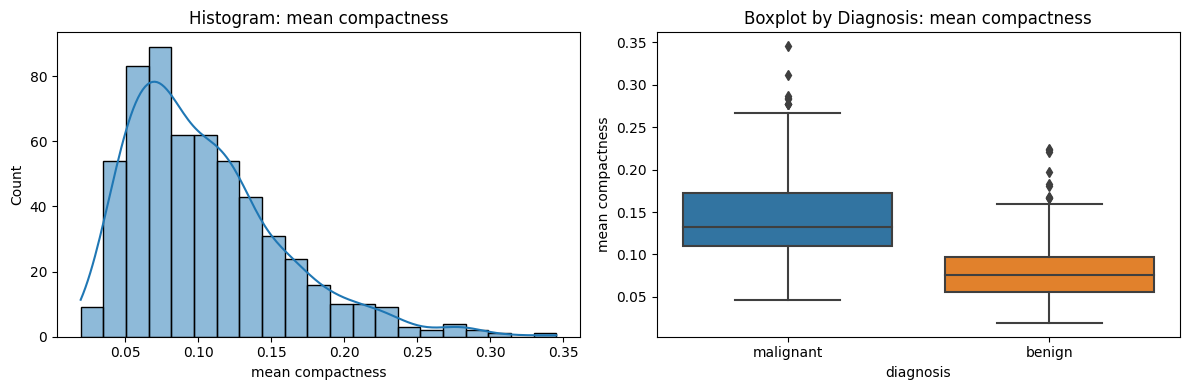

Skewness of  1.4011797389486722


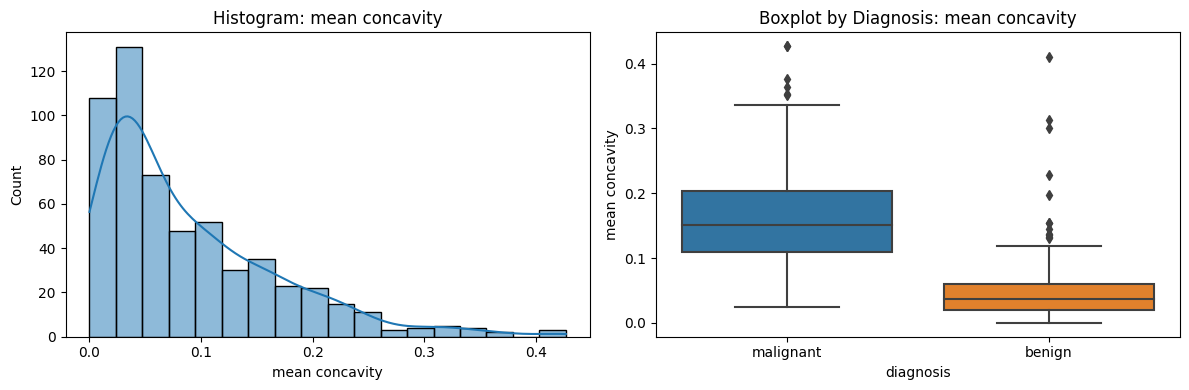

Skewness of  1.1711800812336282


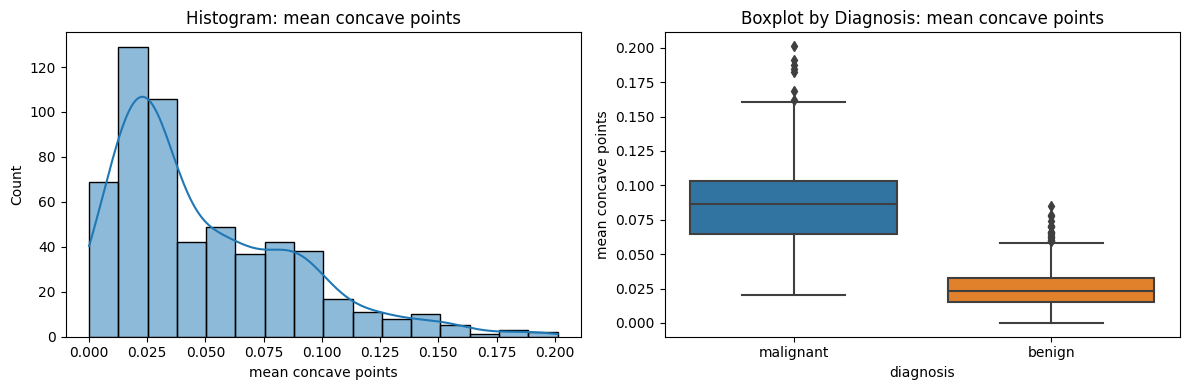

Skewness of  0.7256089733642002


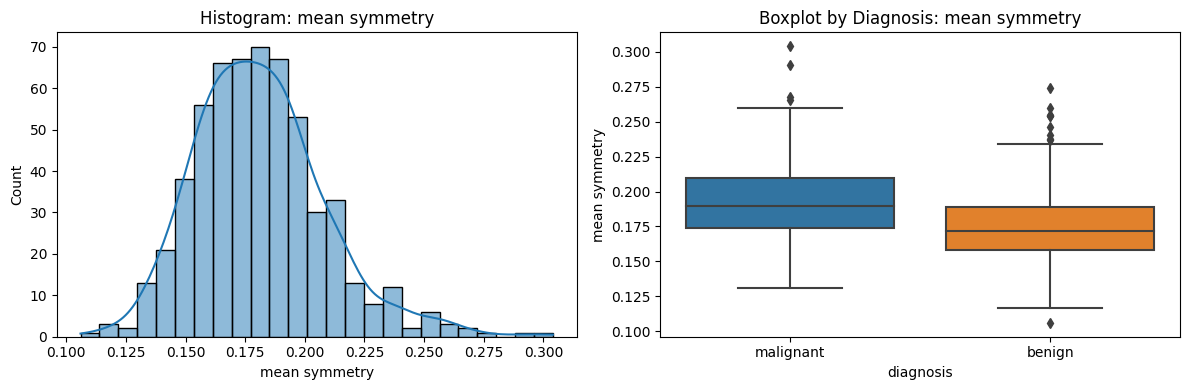

Skewness of  1.304488812575502


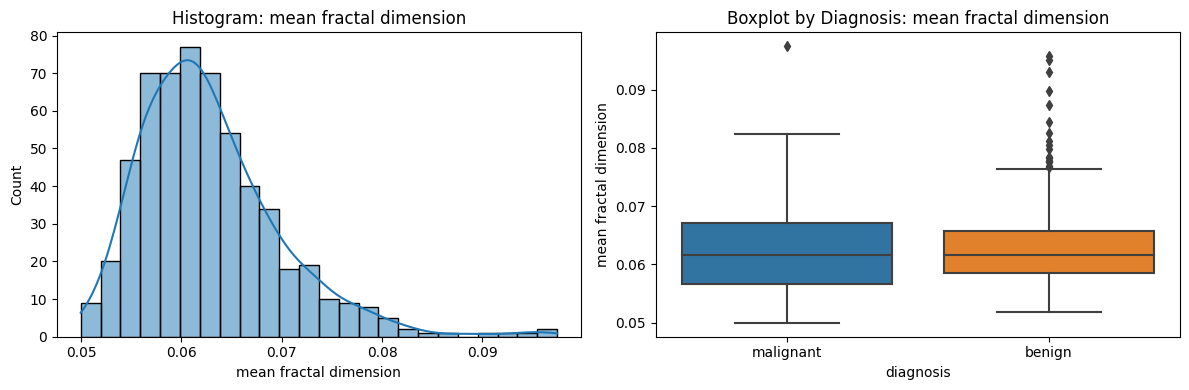

Skewness of  3.0886121663847574


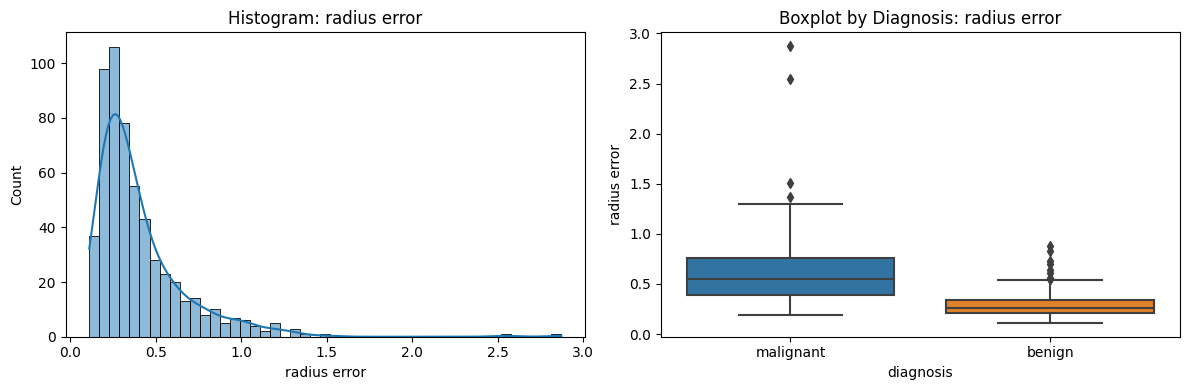

Skewness of  1.646443808753053


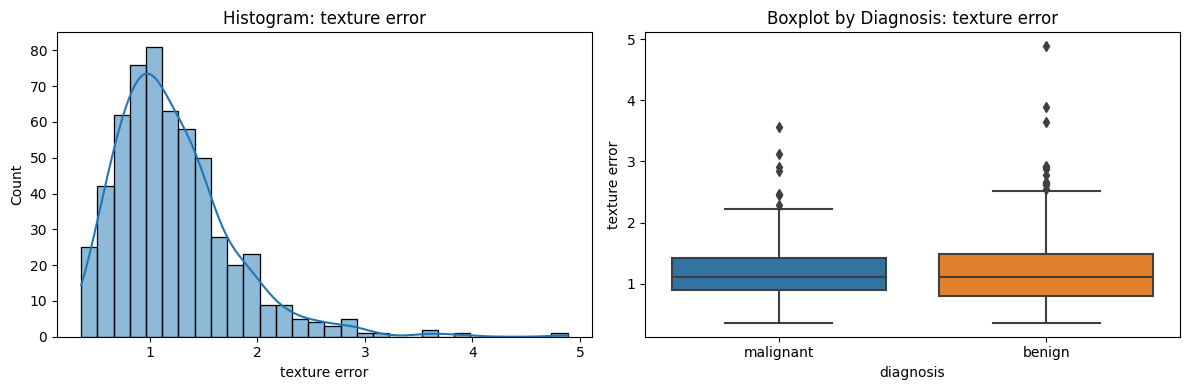

Skewness of  3.443615202194899


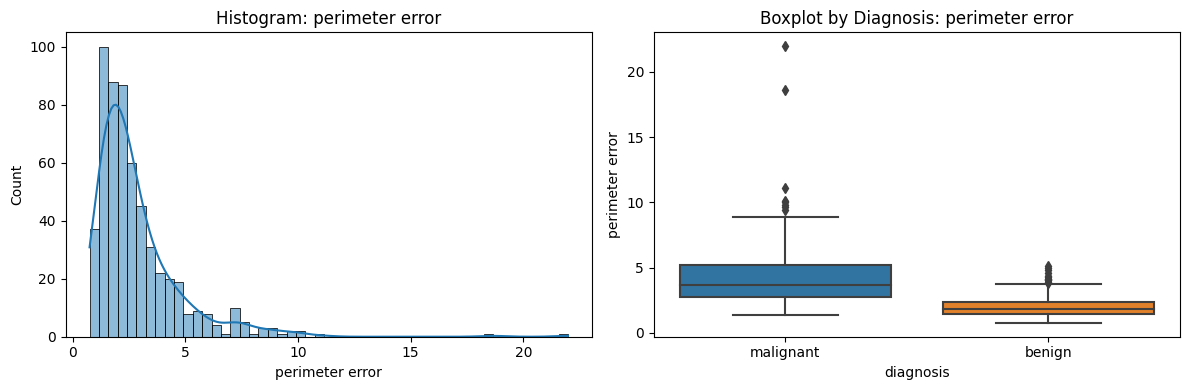

Skewness of  5.447186284898394


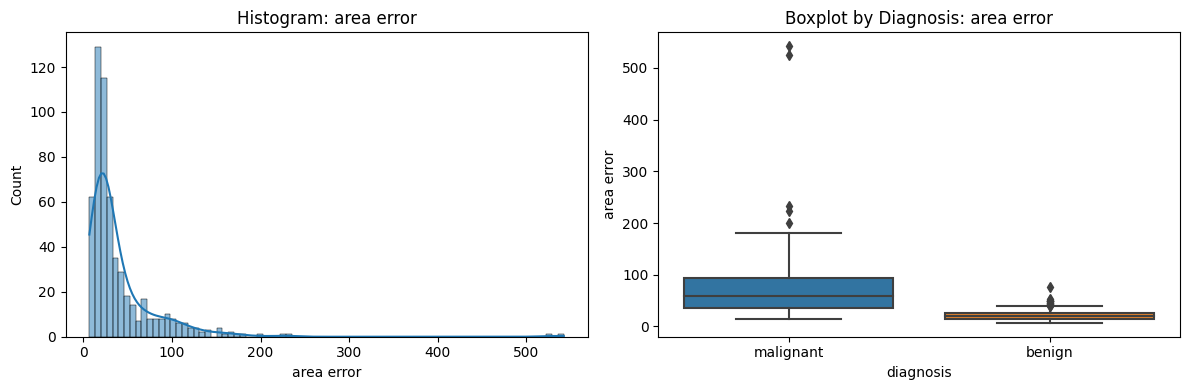

Skewness of  2.314450056636759


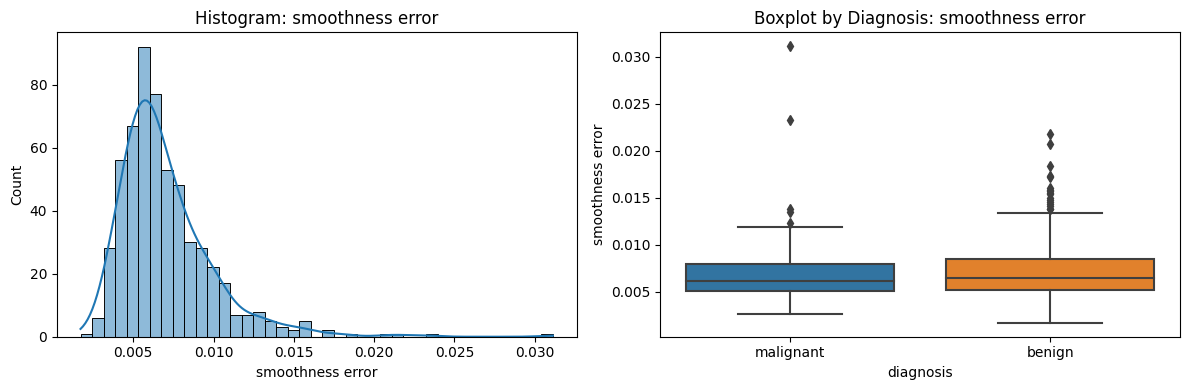

Skewness of  1.9022207096378572


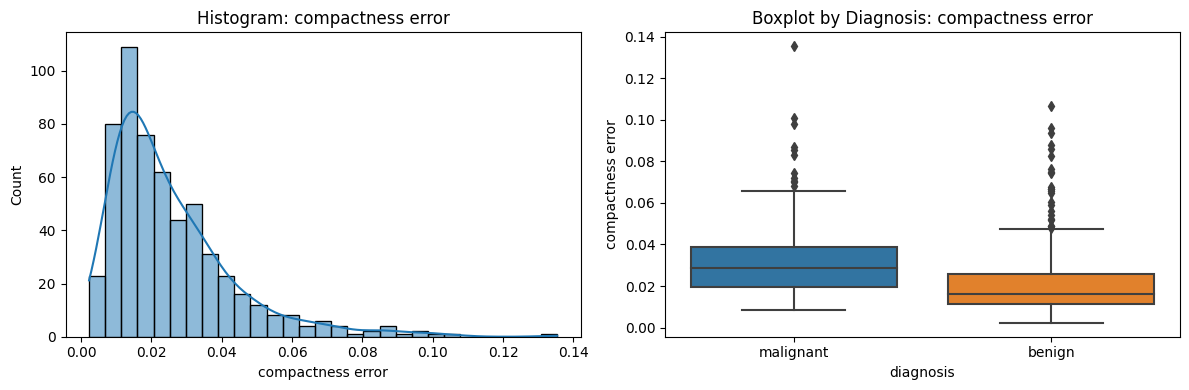

Skewness of  5.11046304904366


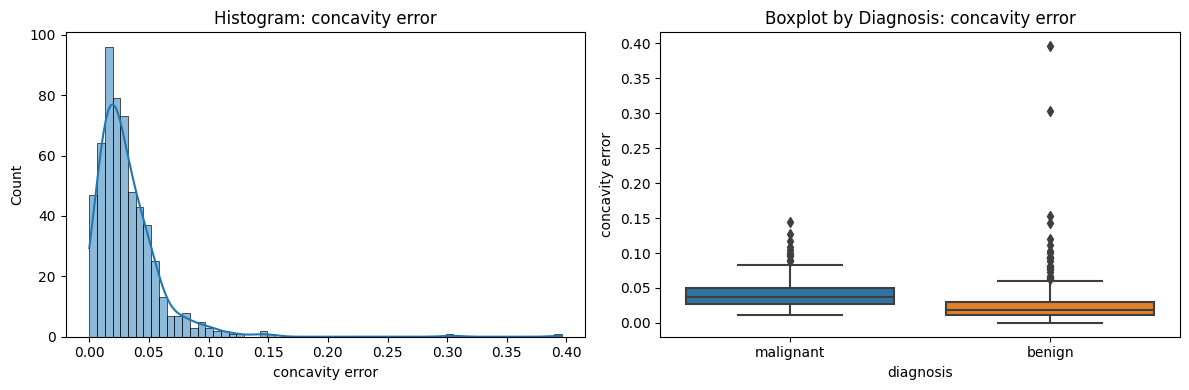

Skewness of  1.4446781446974788


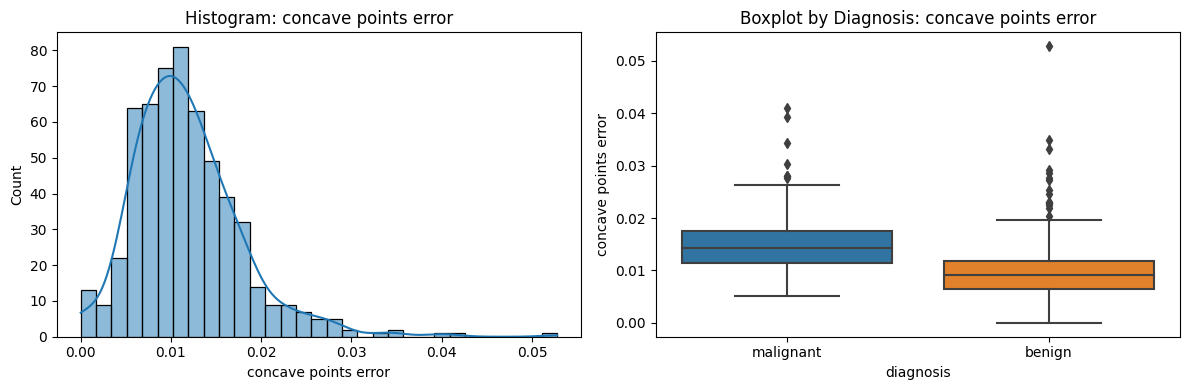

Skewness of  2.1951328995478216


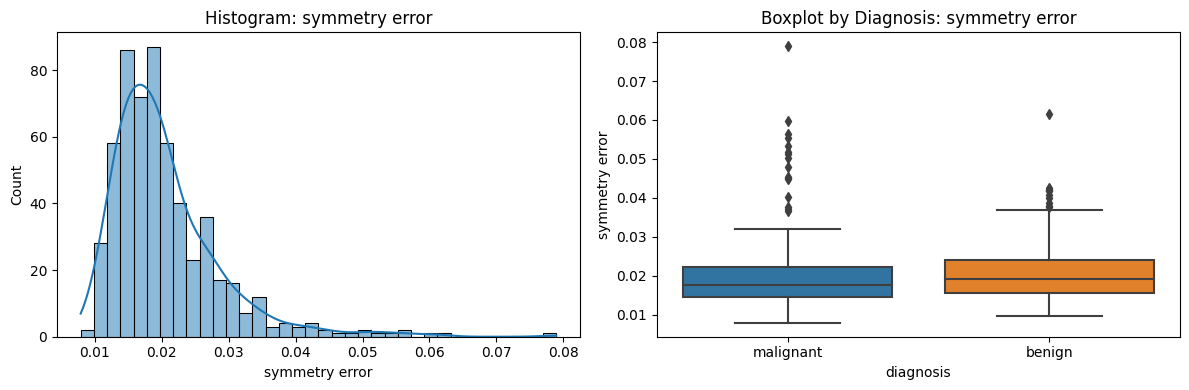

Skewness of  3.9239686202274124


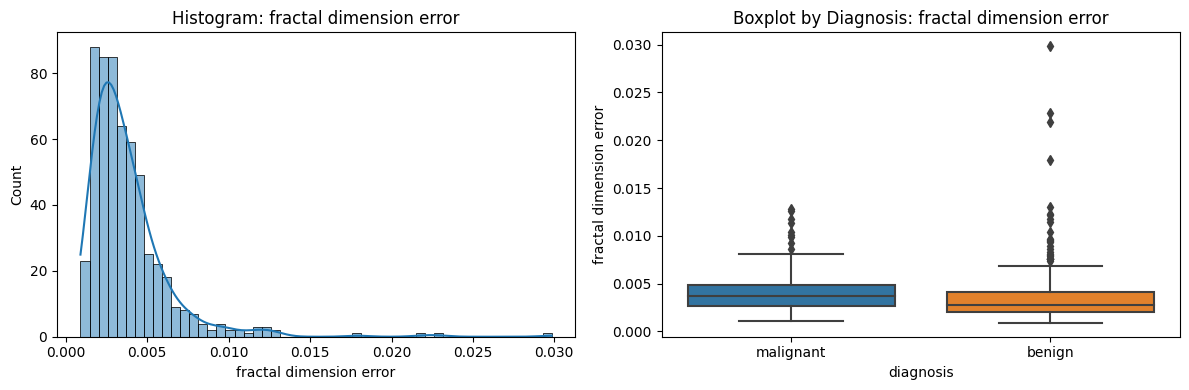

Skewness of  1.1031152059604419


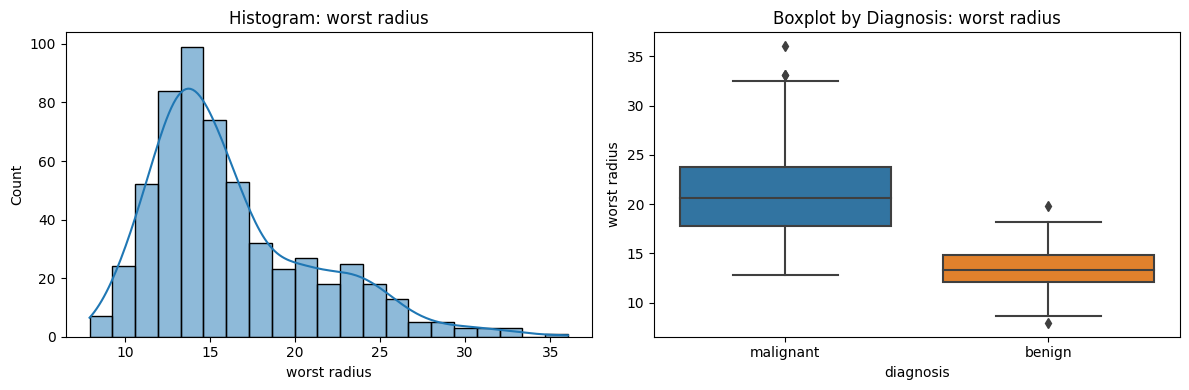

Skewness of  0.4983213094871647


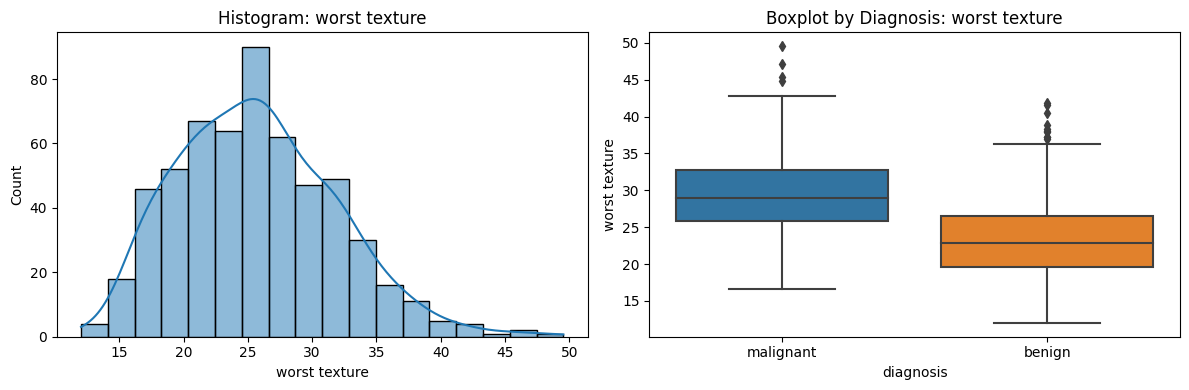

Skewness of  1.1281638713683717


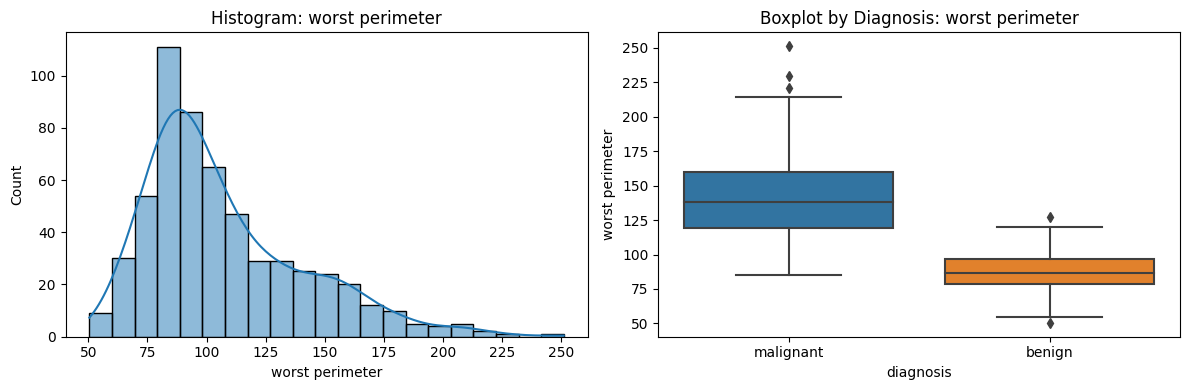

Skewness of  1.8593732724433467


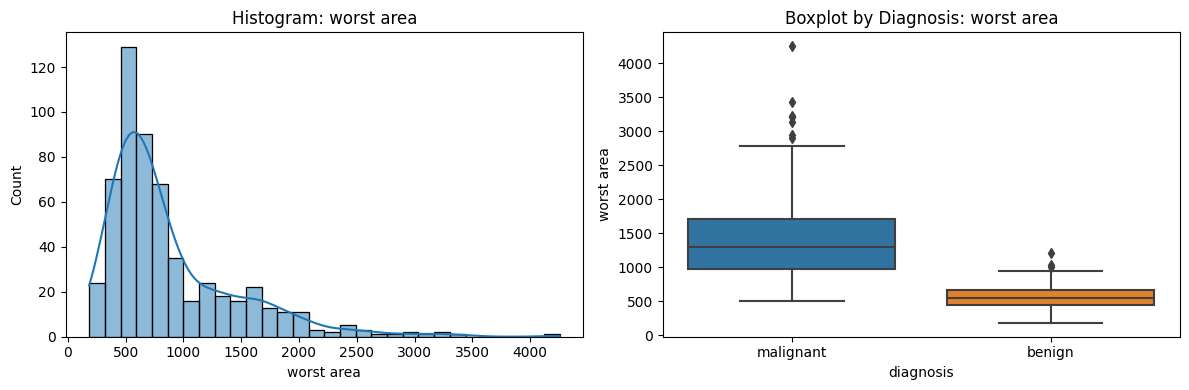

Skewness of  0.4154259962824642


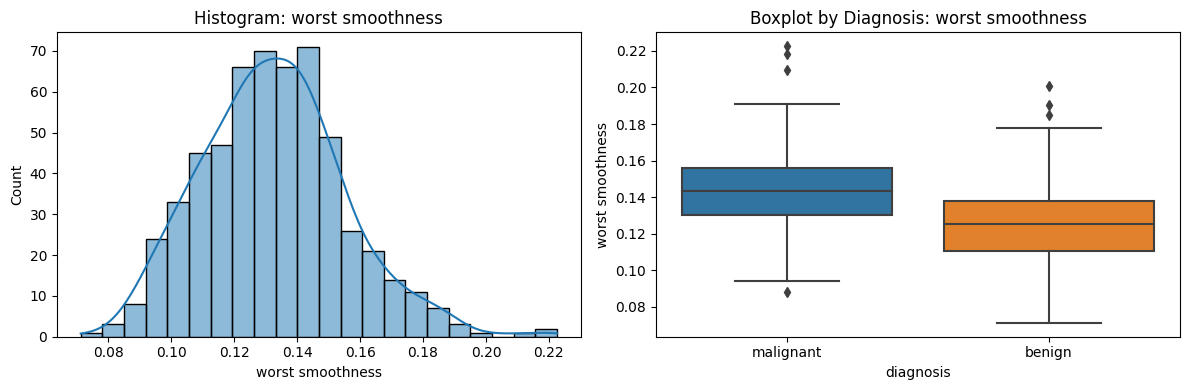

Skewness of  1.4735549003297965


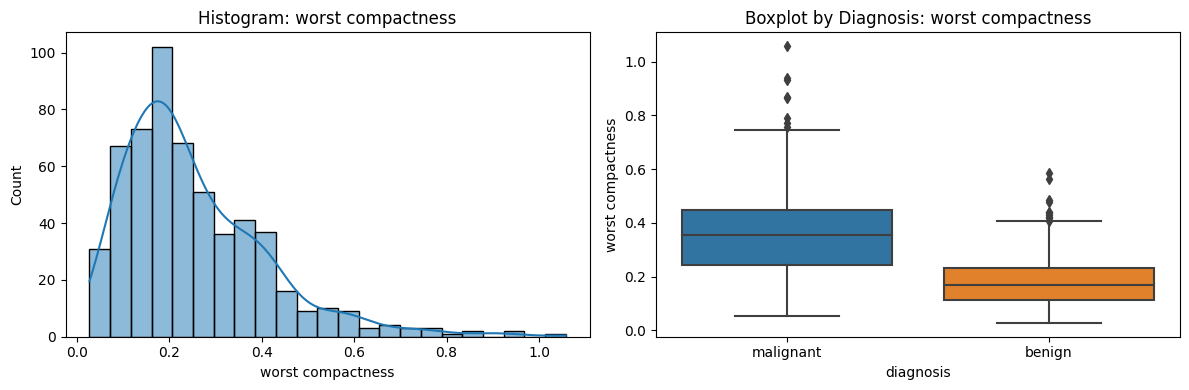

Skewness of  1.1502368219460262


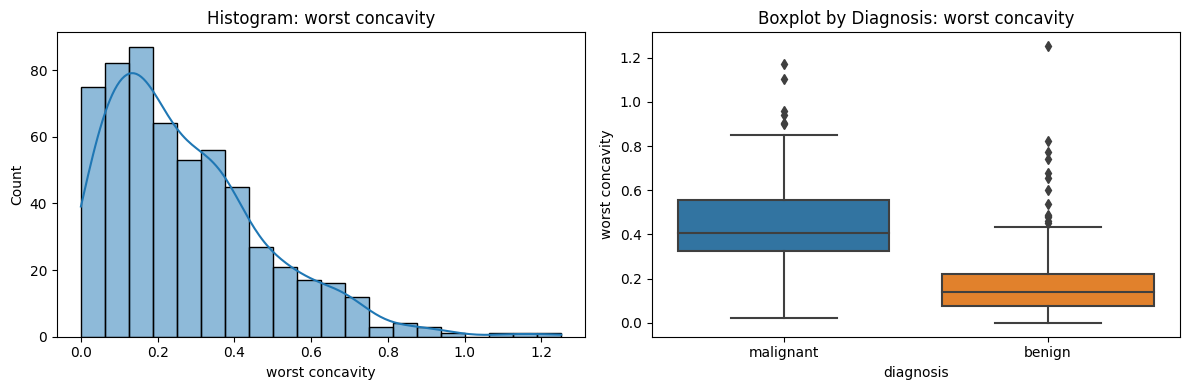

Skewness of  0.49261552688550875


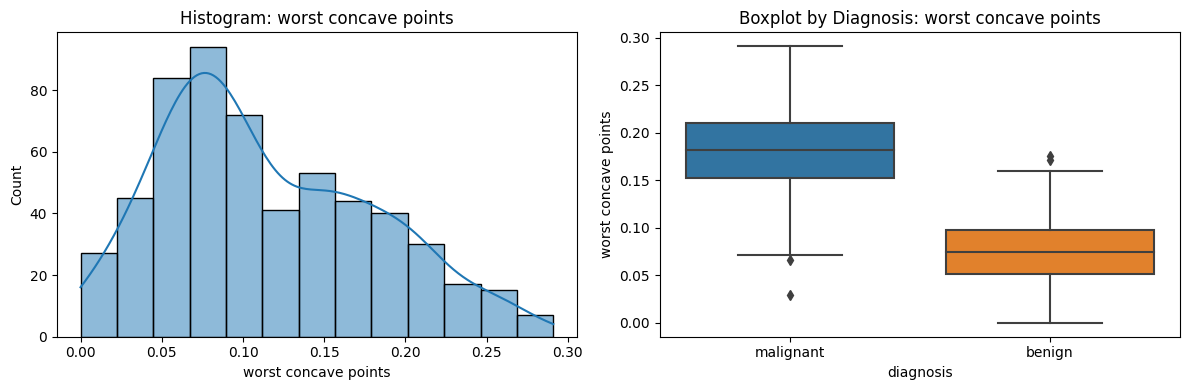

Skewness of  1.4339277651893279


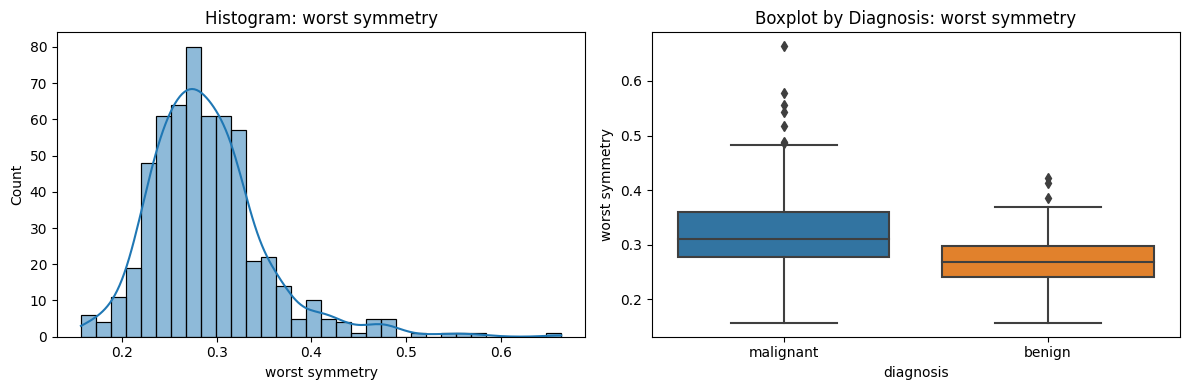

Skewness of  1.6625792663955146


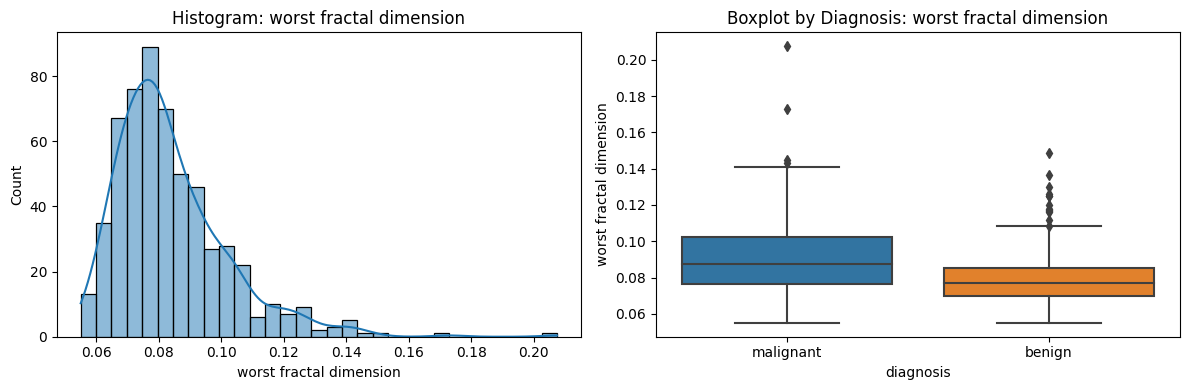

In [10]:
for col in data.feature_names[:]: 
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    print("Skewness of ", df[col].skew())
    sns.histplot(df[col], kde=True, ax=ax[0])
    sns.boxplot(x='diagnosis', y=col, data=df, ax=ax[1])
    
    ax[0].set_title(f"Histogram: {col}")
    ax[1].set_title(f"Boxplot by Diagnosis: {col}")
    
    plt.tight_layout()
    plt.show()


## Correlation and Pairplot

### Correlation

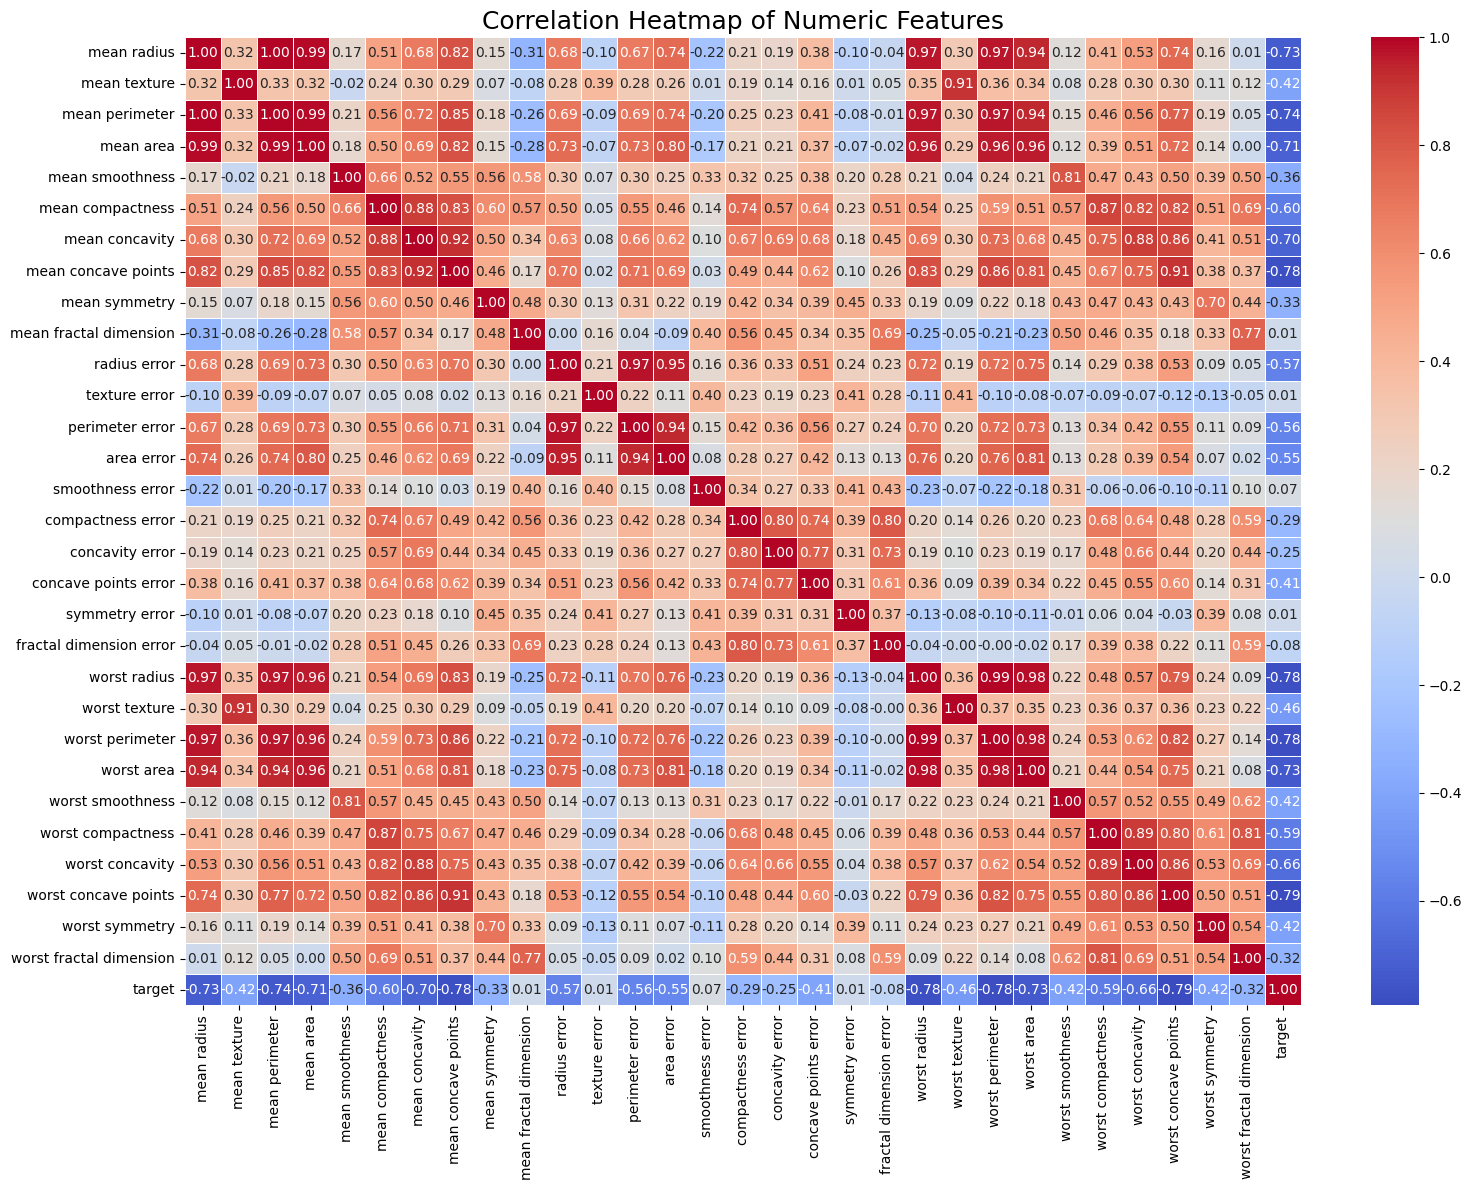

In [11]:
num_cols = df.select_dtypes(include='number')

plt.figure(figsize=(16, 12))
sns.heatmap(num_cols.corr(), annot=True, cmap="coolwarm", linewidths=0.5, fmt=".2f")
plt.title("Correlation Heatmap of Numeric Features", fontsize=18)
plt.tight_layout()
plt.show()


### Pairplot 


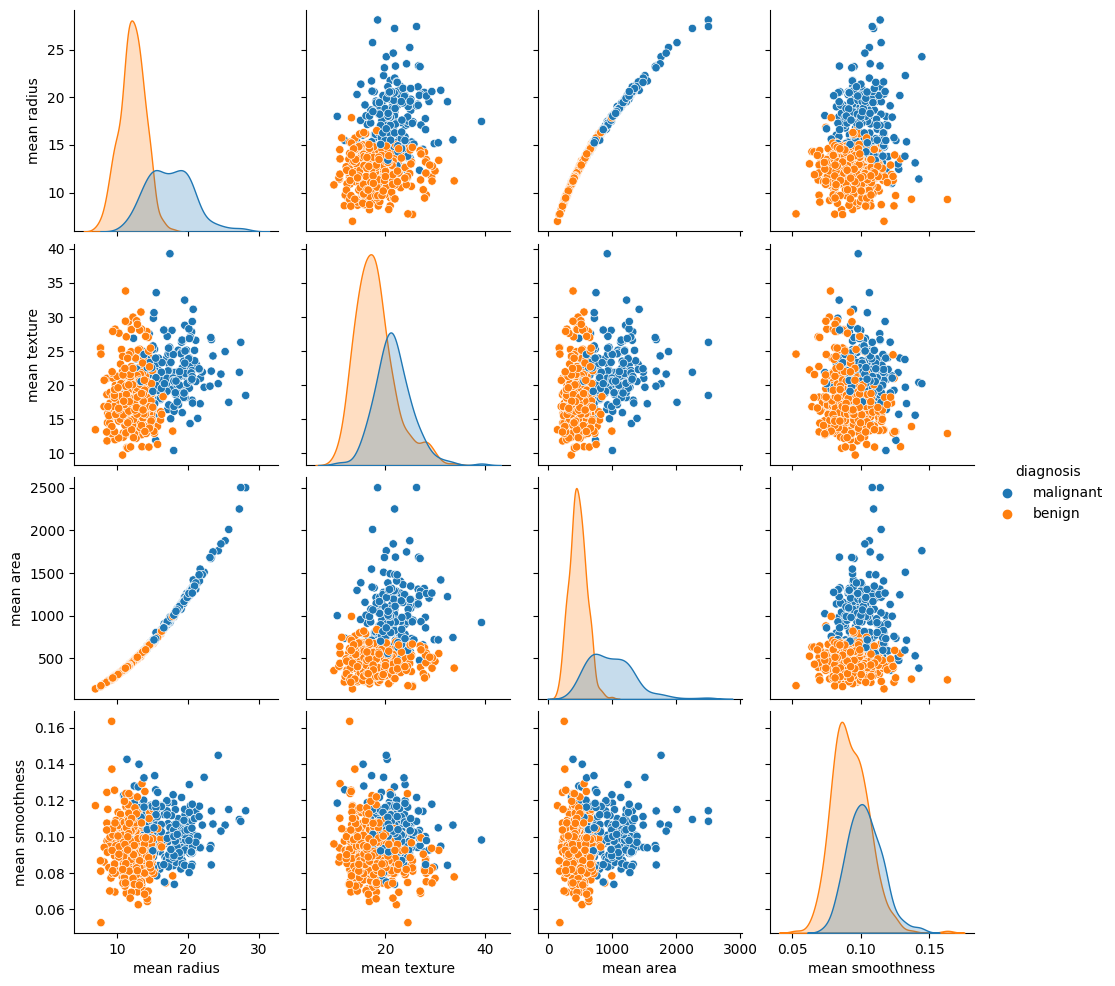

In [12]:
sns.pairplot(df[['mean radius', 'mean texture', 'mean area', 'mean smoothness', 'diagnosis']], hue='diagnosis')
plt.show()

## Statistical Tests

In [14]:
print("\n T-Tests for Numerical Features (malignant vs benign):\n")
for col in data.feature_names:
    t_stat, p_val = stats.ttest_ind(df[df['target'] == 1][col], df[df['target'] == 0][col])
    print(f"{col:<25} p-value: {p_val:.5f}")




 T-Tests for Numerical Features (malignant vs benign):

mean radius               p-value: 0.00000
mean texture              p-value: 0.00000
mean perimeter            p-value: 0.00000
mean area                 p-value: 0.00000
mean smoothness           p-value: 0.00000
mean compactness          p-value: 0.00000
mean concavity            p-value: 0.00000
mean concave points       p-value: 0.00000
mean symmetry             p-value: 0.00000
mean fractal dimension    p-value: 0.75994
radius error              p-value: 0.00000
texture error             p-value: 0.84333
perimeter error           p-value: 0.00000
area error                p-value: 0.00000
smoothness error          p-value: 0.11030
compactness error         p-value: 0.00000
concavity error           p-value: 0.00000
concave points error      p-value: 0.00000
symmetry error            p-value: 0.87664
fractal dimension error   p-value: 0.06307
worst radius              p-value: 0.00000
worst texture             p-value: 0.000

## Feature Selection: VIF

In [15]:
X = df[data.feature_names]
vif_df = pd.DataFrame()
vif_df['Feature'] = X.columns
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_df.sort_values('VIF', ascending=False).head(10))

                    Feature           VIF
0               mean radius  63306.172036
2            mean perimeter  58123.586079
20             worst radius   9674.742602
22          worst perimeter   4487.781270
3                 mean area   1287.262339
23               worst area   1138.759252
9    mean fractal dimension    629.679874
29  worst fractal dimension    423.396723
4           mean smoothness    393.398166
24         worst smoothness    375.597155


# Train-Test Split

In [18]:
X = df[data.feature_names]
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


# Outlier Detection and Removal

In [19]:
from scipy.stats import zscore

for col in num_cols:
    if col!= 'target':
        if abs(X_train[col].skew()) > 1:
            Q1, Q3 = X_train[col].quantile([0.25, 0.75])
            IQR = Q3 - Q1
            lower, upper = Q1 - 3*IQR, Q3 + 3*IQR
            outliers_b = X_train[(X_train[col] < lower) | (X_train[col] > upper)] 
            X_train[col] = X_train[col].where((X_train[col] >= lower) & (X_train[col] <= upper))
            outliers_a = X_train[(X_train[col] < lower) | (X_train[col] > upper)] 
        else:
            z_scores = zscore(X_train[col])
            outliers_b = X_train[np.abs(z_scores) > 3] 
            X_train[col] = X_train[col].where(np.abs(z_scores) <= 3)
            outliers_a = X_train[np.abs(z_scores) > 3] 

        print(f"{col}: {len(outliers_b)} Outliers Before") 
        print(f"{col}: {len(outliers_a)} Outliers After \n\n")

mean radius: 4 Outliers Before
mean radius: 4 Outliers After 


mean texture: 4 Outliers Before
mean texture: 4 Outliers After 


mean perimeter: 5 Outliers Before
mean perimeter: 5 Outliers After 


mean area: 4 Outliers Before
mean area: 0 Outliers After 


mean smoothness: 4 Outliers Before
mean smoothness: 4 Outliers After 


mean compactness: 1 Outliers Before
mean compactness: 0 Outliers After 


mean concavity: 0 Outliers Before
mean concavity: 0 Outliers After 


mean concave points: 0 Outliers Before
mean concave points: 0 Outliers After 


mean symmetry: 5 Outliers Before
mean symmetry: 5 Outliers After 


mean fractal dimension: 3 Outliers Before
mean fractal dimension: 0 Outliers After 


radius error: 8 Outliers Before
radius error: 0 Outliers After 


texture error: 4 Outliers Before
texture error: 0 Outliers After 


perimeter error: 12 Outliers Before
perimeter error: 0 Outliers After 


area error: 17 Outliers Before
area error: 0 Outliers After 


smoothness error: 7 

# Pipeline

In [20]:
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, X.columns)
])

model = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, max_iter=1000)

pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', model)
])


# Model Training


In [21]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]


# Evaluation

In [22]:
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.98      0.95        42
           1       0.99      0.96      0.97        72

    accuracy                           0.96       114
   macro avg       0.96      0.97      0.96       114
weighted avg       0.97      0.96      0.97       114

Accuracy: 0.9649122807017544
Precision: 0.9857142857142858
Recall: 0.9583333333333334
F1 Score: 0.971830985915493


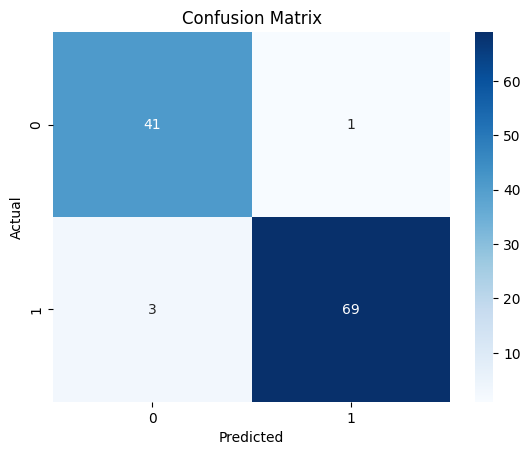

In [23]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

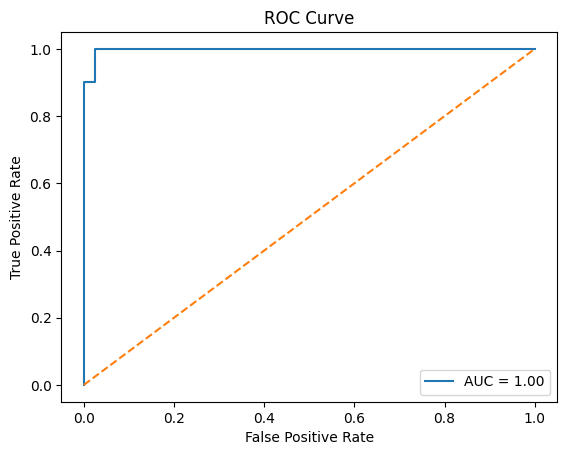

In [25]:
y_probs = pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_probs):.2f}")
plt.plot([0, 1], [0, 1], '--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

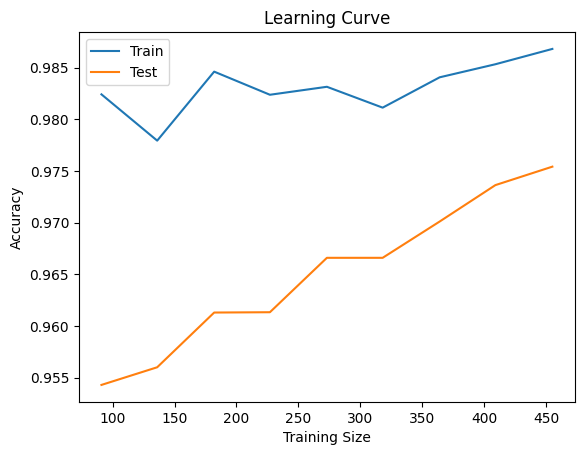

In [27]:
train_sizes, train_scores, test_scores = learning_curve(
    pipeline, X, y, cv=5, scoring='accuracy', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
)

train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

plt.plot(train_sizes, train_scores_mean, label="Train")
plt.plot(train_sizes, test_scores_mean, label="Test")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend()
plt.show()

# SHAP

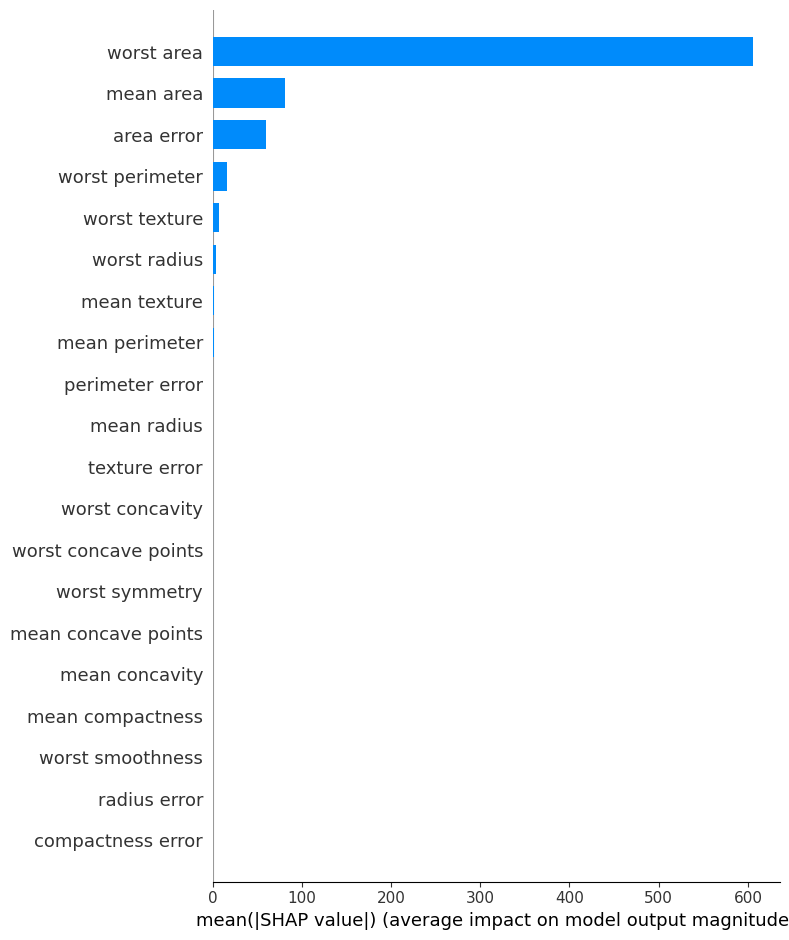

In [28]:
explainer = shap.Explainer(pipeline.named_steps['classifier'], X_test)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")

# Base Model Save

In [29]:
joblib.dump(pipeline, "breast_cancer_model.joblib")
print("\n Base model saved as 'breast_cancer_model.joblib'")



 Base model saved as 'breast_cancer_model.joblib'
